In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By # Importa By para localizar elementos
from selenium.common.exceptions import NoSuchElementException, TimeoutException
import time
import os

CHROME_DRIVER_PATH = 'drivers/chromedriver.exe'


IMDB_URL = "https://www.imdb.com/chart/top/"

titulos = []
anos = []
avaliacoes = []

print("Iniciando o Web Scraper do IMDb...")

try:
    service = Service(executable_path=CHROME_DRIVER_PATH)

    # Inicia o navegador Chrome
    driver = webdriver.Chrome(service=service)
    print("Navegador Chrome iniciado.")

    driver.implicitly_wait(10)

    driver.get(IMDB_URL)
    print(f"Acessando a URL: {IMDB_URL}")
    time.sleep(3)

    movie_items = driver.find_elements(By.CLASS_NAME, 'ipc-metadata-list-summary-item__tc')

    print(f"Encontrados {len(movie_items)} filmes na página.")

    for movie in movie_items:
        try:

            title_element = movie.find_element(By.CLASS_NAME, 'ipc-title__text')
            title = title_element.text.split('.', 1)[-1].strip()
            
            year_element = movie.find_element(By.CLASS_NAME, 'sc-86fea7d1-8') #Ao analisar o HTML identifiquei que o elemento sc-b069fe27-8 foi trocado por sc-86fea7d1-8
            year = year_element.text.strip()
            
            rating_element = movie.find_element(By.CLASS_NAME, 'ipc-rating-star--rating')
            rating_text = rating_element.text.strip()

            titulos.append(title)
            anos.append(year)
            avaliacoes.append(rating_text)
            
            print(f"Coletado: Título: '{title}', Ano: '{year}', Avaliação: '{rating_text}'")

        except NoSuchElementException as e:
            print(f"Erro ao encontrar um elemento para um filme (pode ser algum elemento ausente): {e}")
            titulos.append('N/A')
            anos.append('N/A')
            avaliacoes.append('N/A')
        except Exception as e:
            print(f"Ocorreu um erro inesperado ao processar um filme: {e}")
            titulos.append('N/A')
            anos.append('N/A')
            avaliacoes.append('N/A')


except TimeoutException:
    print("Tempo limite excedido. A página pode não ter carregado a tempo.")
except Exception as e:
    print(f"Ocorreu um erro ao iniciar ou processar o scraping: {e}")

finally:
    if 'driver' in locals() and driver: # Garante que o driver foi inicializado antes de tentar fechar
        driver.quit()
        print("Navegador Chrome fechado.")

print("\n--- Dados Coletados ---")
for i in range(len(titulos)):
    print(f"Título: {titulos[i]}, Ano: {anos[i]}, Avaliação: {avaliacoes[i]}")

print(f"\nTotal de filmes coletados: {len(titulos)}")

# No próximo passo, vamos transformar isso em um DataFrame Pandas!

Iniciando o Web Scraper do IMDb...
Navegador Chrome iniciado.
Acessando a URL: https://www.imdb.com/chart/top/
Encontrados 250 filmes na página.
Coletado: Título: 'Um Sonho de Liberdade', Ano: '1994', Avaliação: '9,3'
Coletado: Título: 'O Poderoso Chefão', Ano: '1972', Avaliação: '9,2'
Coletado: Título: 'Batman: O Cavaleiro das Trevas', Ano: '2008', Avaliação: '9,0'
Coletado: Título: 'O Poderoso Chefão: Parte II', Ano: '1974', Avaliação: '9,0'
Coletado: Título: '12 Homens e uma Sentença', Ano: '1957', Avaliação: '9,0'
Coletado: Título: 'O Senhor dos Anéis: O Retorno do Rei', Ano: '2003', Avaliação: '9,0'
Coletado: Título: 'A Lista de Schindler', Ano: '1993', Avaliação: '9,0'
Coletado: Título: 'Pulp Fiction: Tempo de Violência', Ano: '1994', Avaliação: '8,8'
Coletado: Título: 'O Senhor dos Anéis: A Sociedade do Anel', Ano: '2001', Avaliação: '8,9'
Coletado: Título: 'Três Homens em Conflito', Ano: '1966', Avaliação: '8,8'
Coletado: Título: 'Forrest Gump: O Contador de Histórias', Ano: '1

In [2]:
print("\n--- Iniciando Organização e Limpeza de Dados ---")
import pandas as pd
import numpy as np

df_filmes = pd.DataFrame({
    'Titulo': titulos,
    'Ano': anos,
    'Avaliacao': avaliacoes
})

# ATENÇÃO: Adicionei .copy() aqui para evitar o SettingWithCopyWarning
df_filmes_limpo = df_filmes[~(
    (df_filmes['Titulo'] == 'N/A') |
    (df_filmes['Ano'] == 'N/A') |
    (df_filmes['Avaliacao'] == 'N/A')
)].copy()

print(f"\nDataFrame após remover entradas 'N/A'. Filmes removidos: {len(df_filmes) - len(df_filmes_limpo)}")
print(df_filmes_limpo.head())

df_filmes_limpo['Avaliacao'] = df_filmes_limpo['Avaliacao'].str.replace(',', '.', regex=False)

df_filmes_limpo.loc[:, 'Ano'] = pd.to_numeric(df_filmes_limpo['Ano'], errors='coerce')
df_filmes_limpo.loc[:, 'Avaliacao'] = pd.to_numeric(df_filmes_limpo['Avaliacao'], errors='coerce')


df_filmes_limpo.dropna(inplace=True)

df_filmes_limpo.loc[:, 'Ano'] = df_filmes_limpo['Ano'].astype(int)

print("\nDataFrame após conversão de tipos e remoção de NaNs:")
print(df_filmes_limpo.info())
print(df_filmes_limpo.describe())

print("\nDados organizados e limpos com sucesso!")
print(df_filmes_limpo.head())
# Você pode salvar o DataFrame para uso futuro, se quiser
# df_filmes_limpo.to_csv('filmes_imdb_limpo.csv', index=False, encoding='utf-8')
# print("\nDados salvos em 'filmes_imdb_limpo.csv'")


--- Iniciando Organização e Limpeza de Dados ---

DataFrame após remover entradas 'N/A'. Filmes removidos: 0
                           Titulo   Ano Avaliacao
0           Um Sonho de Liberdade  1994       9,3
1               O Poderoso Chefão  1972       9,2
2  Batman: O Cavaleiro das Trevas  2008       9,0
3     O Poderoso Chefão: Parte II  1974       9,0
4        12 Homens e uma Sentença  1957       9,0

DataFrame após conversão de tipos e remoção de NaNs:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Titulo     250 non-null    object
 1   Ano        250 non-null    object
 2   Avaliacao  250 non-null    object
dtypes: object(3)
memory usage: 6.0+ KB
None
              Titulo   Ano  Avaliacao
count            250   250      250.0
unique           249    85       13.0
top     Os Suspeitos  1995        8.1
freq               2     8       72.0

D


--- Iniciando Análise Exploratória de Dados e Visualização REFORMULADA ---

Estatísticas Detalhadas das Avaliações (Top 250):
count     250.0
unique     13.0
top         8.1
freq       72.0
Name: Avaliacao, dtype: float64


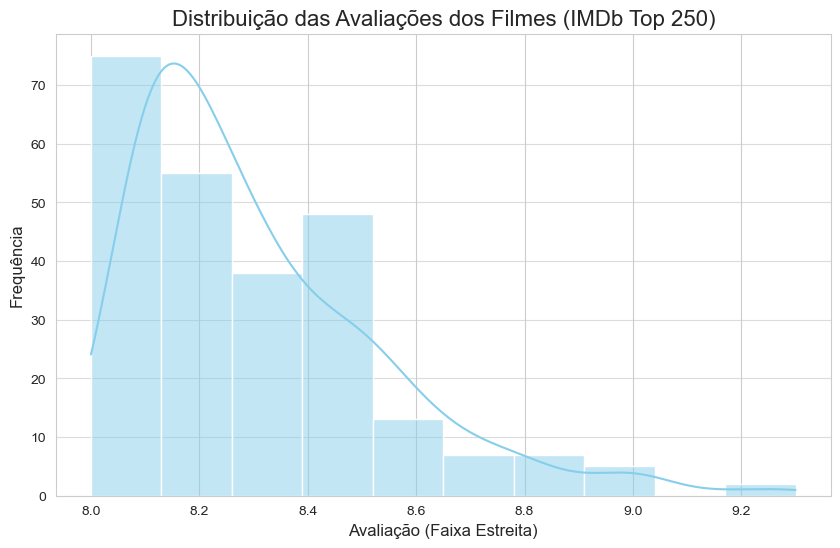


Contagem de Filmes por Década (Top 250):
Decada
1920     6
1930     6
1940    11
1950    21
1960    16
1970    19
1980    26
1990    40
2000    47
2010    45
2020    13
Name: count, dtype: int64


C:\Users\gusta\AppData\Local\Temp\ipykernel_2480\2815673253.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=filmes_por_decada.index, y=filmes_por_decada.values, palette='viridis')


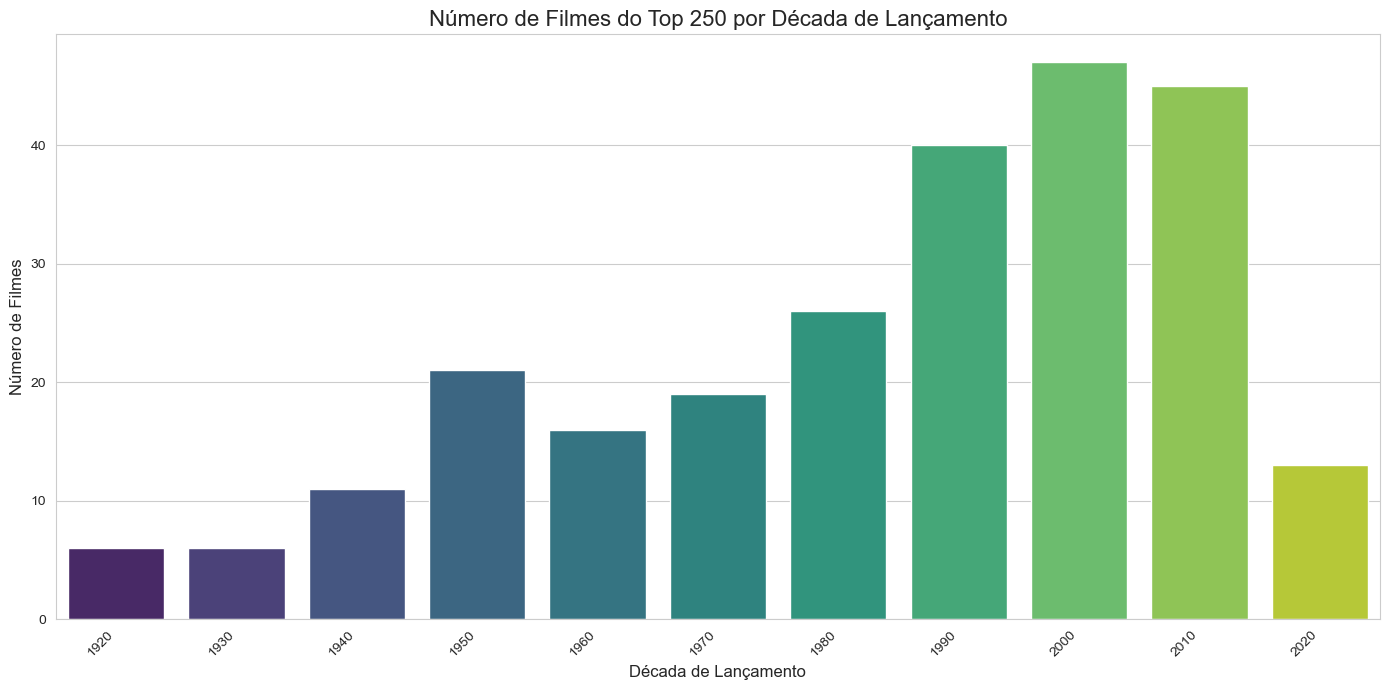


Avaliação Média por Década (Top 250):
   Decada Avaliacao
0    1920  8.166667
1    1930  8.283333
2    1940  8.263636
3    1950  8.280952
4    1960    8.3375


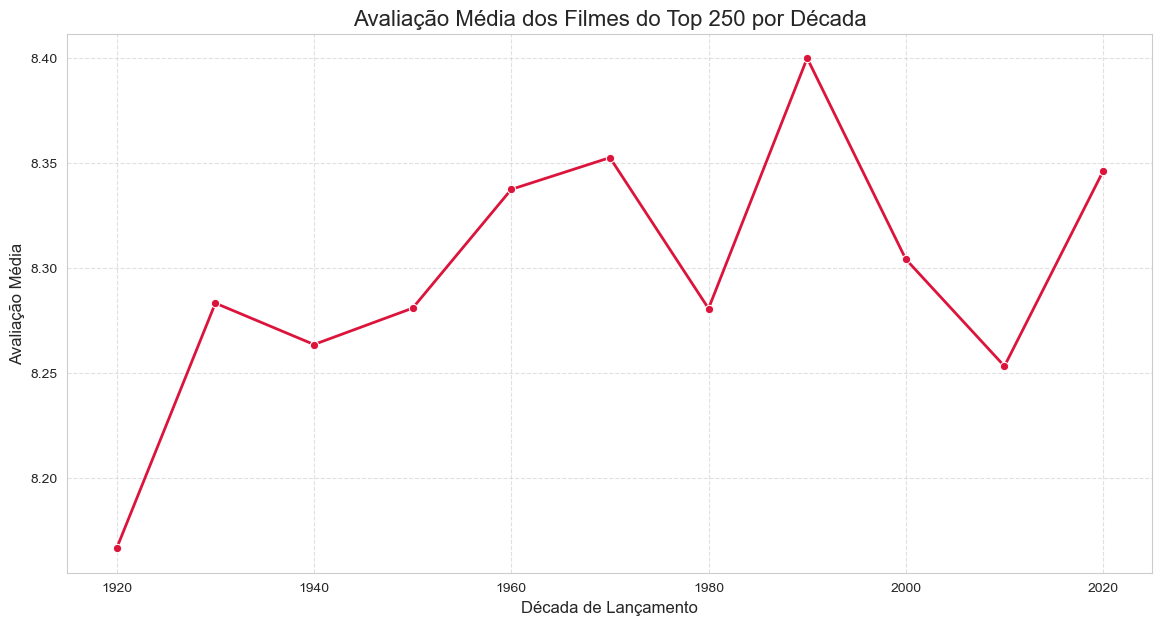

C:\Users\gusta\AppData\Local\Temp\ipykernel_2480\2815673253.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Decada', y='Avaliacao', data=df_filmes_limpo, palette='coolwarm')


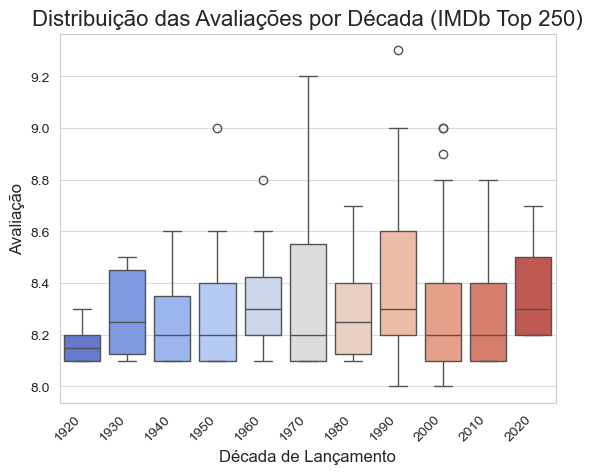

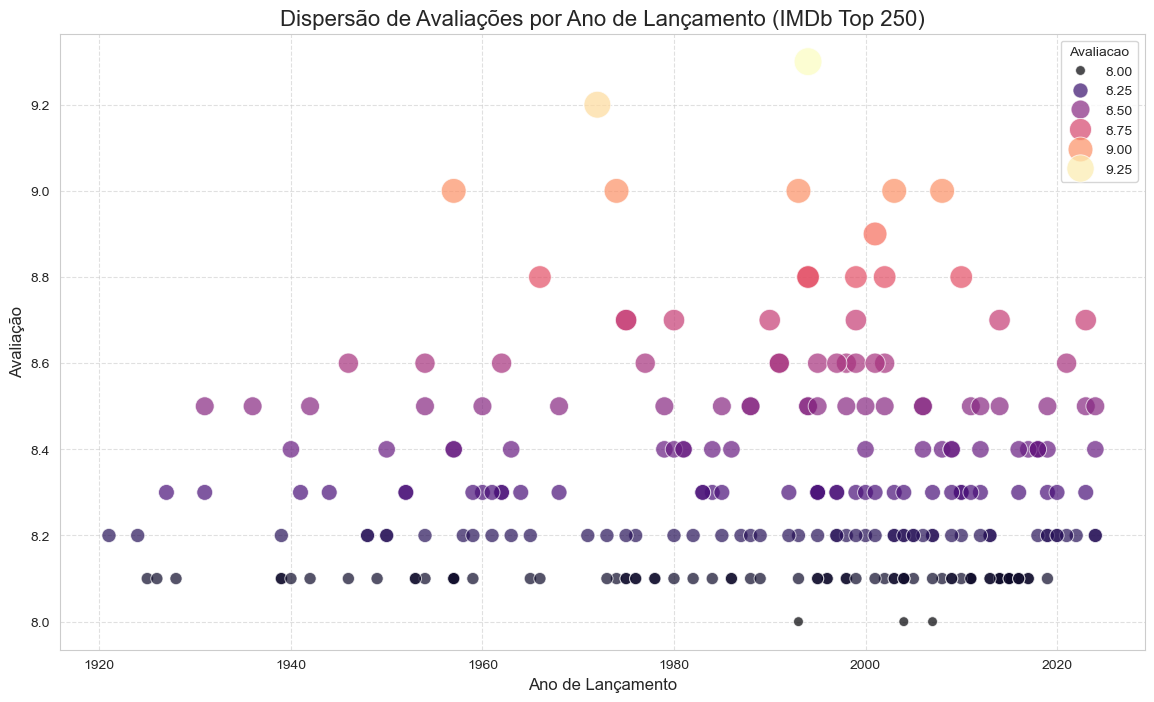


Análise Exploratória de Dados e Visualização REFORMULADA concluídas!


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Iniciando Análise Exploratória de Dados e Visualização REFORMULADA ---")

# Configuração estética dos gráficos com Seaborn
sns.set_style("whitegrid")
sns.set_palette("deep")

# Análise da Distribuição das Avaliações 
print("\nEstatísticas Detalhadas das Avaliações (Top 250):")
print(df_filmes_limpo['Avaliacao'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df_filmes_limpo['Avaliacao'], kde=True, bins=10, color='skyblue')
plt.title('Distribuição das Avaliações dos Filmes (IMDb Top 250)', fontsize=16)
plt.xlabel('Avaliação (Faixa Estreita)', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', alpha=0.7)
plt.show()

# Contagem de Filmes por Década
df_filmes_limpo['Decada'] = (df_filmes_limpo['Ano'] // 10) * 10
filmes_por_decada = df_filmes_limpo['Decada'].value_counts().sort_index()
print("\nContagem de Filmes por Década (Top 250):")
print(filmes_por_decada)

plt.figure(figsize=(14, 7))
sns.barplot(x=filmes_por_decada.index, y=filmes_por_decada.values, palette='viridis')
plt.title('Número de Filmes do Top 250 por Década de Lançamento', fontsize=16)
plt.xlabel('Década de Lançamento', fontsize=12)
plt.ylabel('Número de Filmes', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Avaliação Média por Década
avaliacao_media_por_decada = df_filmes_limpo.groupby('Decada')['Avaliacao'].mean().reset_index()

print("\nAvaliação Média por Década (Top 250):")
print(avaliacao_media_por_decada.head())

plt.figure(figsize=(14, 7))
sns.lineplot(x='Decada', y='Avaliacao', data=avaliacao_media_por_decada, marker='o', color='crimson', linewidth=2)
plt.title('Avaliação Média dos Filmes do Top 250 por Década', fontsize=16)
plt.xlabel('Década de Lançamento', fontsize=12)
plt.ylabel('Avaliação Média', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Box Plot de Avaliações por Década 
sns.boxplot(x='Decada', y='Avaliacao', data=df_filmes_limpo, palette='coolwarm')
plt.title('Distribuição das Avaliações por Década (IMDb Top 250)', fontsize=16)
plt.xlabel('Década de Lançamento', fontsize=12)
plt.ylabel('Avaliação', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', alpha=0.7)
plt.show()


# Dispersão de Avaliações por Ano para ver outliers ou padrões mais sutis
plt.figure(figsize=(14, 8))
sns.scatterplot(x='Ano', y='Avaliacao', data=df_filmes_limpo,
                alpha=0.7,
                hue='Avaliacao',
                size='Avaliacao', 
                sizes=(50, 400), 
                palette='magma')
plt.title('Dispersão de Avaliações por Ano de Lançamento (IMDb Top 250)', fontsize=16)
plt.xlabel('Ano de Lançamento', fontsize=12)
plt.ylabel('Avaliação', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("\nAnálise Exploratória de Dados e Visualização REFORMULADA concluídas!")

# Opcional: Salvar o DataFrame final para uso posterior
# df_filmes_limpo.to_csv('filmes_imdb_analise_top250.csv', index=False, encoding='utf-8')
# print("\nDados finais salvos em 'filmes_imdb_analise_top250.csv'")